## Cleaning FT dataset and basic statistics

In [69]:
import requests
import time
from bs4 import BeautifulSoup
from bs4 import SoupStrainer
import tqdm
import pandas as pd
import numpy as np
import datetime as dt

import matplotlib.pyplot as plt
import seaborn as sns


### Import dataset

In [74]:
# Import FT dataset
ft = pd.read_csv('FT.csv')
display(len(ft))

16689

FT: The raw dataset after scraping XML has 16.689 articles.

### Diverse cleaning operations

#### FT Dataset

In [71]:
## Rows that stem from links to a search page. They have the title "Søg på TV 2" and can be deleted
ft = ft[ft['content'].str.contains("sygeplej")]
# After this step, 7416 observations remain
# In the next step we drop all rows that do not contain values. These are sports artciles like this one: https://sport.tv2.dk/2012-02-26-sur-s%C3%B8d-fornemmelse-hos-kasper-hvidt
# Rename column
ft['source'] = 'FT'
#ft.rename(columns = {'FT':'source'}, inplace = True)
# Reset index
ft = ft.reset_index(drop = True)
# Change date to date_time objects
ft['date'] = pd.to_datetime(ft['date'])
ft['session'] = ft['session'].astype(int)
ft['meetingnumber'] = ft['meetingnumber'].astype(int)
# Drop articles published outside period of interest (2012-2022)
ft = ft[ft['date'].dt.year >= 2012]
display(len(ft))

524

Number of observations: FT dataset now contains 524 articles 

In [72]:
ft

,session,meetingnumber,date,location,group,content,path,source
127,20111,100,2012-09-06,Folketingssalen,Folketinget,Det eneste punkt på dagsordenen er: 1) 1. beha...,/ODAXML/Referat/samling/20111/20111_M100_helem...,FT
128,20111,102,2012-09-13,Folketingssalen,Folketinget,Det næste punkt på dagsordenen er: 3) 3. behan...,/ODAXML/Referat/samling/20111/20111_M102_helem...,FT
134,20111,35,2012-01-18,Folketingssalen,Folketinget,Det sidste punkt på dagsordenen er: 2) Besvare...,/ODAXML/Referat/samling/20111/20111_M35_helemo...,FT
135,20111,39,2012-01-26,Folketingssalen,Folketinget,Det sidste punkt på dagsordenen er: 9) 1. beha...,/ODAXML/Referat/samling/20111/20111_M39_helemo...,FT
136,20111,47,2012-02-09,Folketingssalen,Folketinget,Det næste punkt på dagsordenen er: 8) 1. behan...,/ODAXML/Referat/samling/20111/20111_M47_helemo...,FT
...,...,...,...,...,...,...,...,...
654,20211,94,2022-04-21,Folketingssalen,Folketinget,Det næste punkt på dagsordenen er: 23) 1. beha...,/ODAXML/Referat/samling/20211/20211_M94_helemo...,FT
655,20211,97,2022-04-26,Folketingssalen,Folketinget,Det første punkt på dagsordenen er: 1) Spørget...,/ODAXML/Referat/samling/20211/20211_M97_helemo...,FT
656,20211,97,2022-04-26,Folketingssalen,Folketinget,Det næste punkt på dagsordenen er: 18) 1. beha...,/ODAXML/Referat/samling/20211/20211_M97_helemo...,FT
657,20211,97,2022-04-26,Folketingssalen,Folketinget,Det næste punkt på dagsordenen er: 19) 1. beha...,/ODAXML/Referat/samling/20211/20211_M97_helemo...,FT


#### Columns of FT dataset: 
* `session` contains the session number - Folketingssamling
* `meetingnumber` contains the meetning number within the session
* `date` contains the date of the meeting in the datetime format
* `location` contains the location of the meeting - Folketingssalen
* `group` contains Folketinget
* `title`(to come) contains the articles' title
* `content` contains the transscription of the meeting
* `source` indicates the source (FT) 
* `links` contains the link to the original transscript

#### Cleaning articles' content

In [51]:
def cleaning_texts(df):
    '''
    Function cleans the text of the "content", "titles", "subheaders" and "h2" columns of TV2 and DR datasets.
    '''
    df_new = df.copy()
    for i in ft[['content']]:
        df_new[i] = df_new[i].str.lower()\
            .str.replace('\r', '')\
            .str.replace('\n', '')\
            .str.replace('\xa0', '')
    return df_new

In [52]:
# Cleaning datasets with cleaning function
ft = cleaning_texts(ft)


### Creating more relevant datasets

Creating different DataFrames according to the number of times "sygeplej*" is found in the articles' content. The more frequently the term features in the text, the more relevant the articles' should be for our analysis. 

_For now, we continue working with data in which "sygeplej*" appears at least twice_.

In [53]:
### Defining function

In [54]:
# Create different datasets with "sygeplej*" featuring at least X times in the text
def sygeplej_count(df):
    df_sygeplej1x = df[df['content'].str.count("sygeplej") >= 1]
    df_sygeplej2x = df[df['content'].str.count("sygeplej") >= 2]
    df_sygeplej3x = df[df['content'].str.count("sygeplej") >= 3]
    df_sygeplej4x = df[df['content'].str.count("sygeplej") >= 4]
    return df_sygeplej1x, df_sygeplej2x, df_sygeplej3x, df_sygeplej4x

In [55]:
ft_sygeplej1x, ft_sygeplej2x, ft_sygeplej3x, ft_sygeplej4x = sygeplej_count(ft)

In [56]:
dict_sygeplej_count = {"sygeplej* count":\
                       ['At least once', 'At least twice', 'At least three times', 'More than three times'],\
                       "Num. of articles (FT)" :\
                       [len(ft_sygeplej1x), len(ft_sygeplej2x), len(ft_sygeplej3x), len(ft_sygeplej4x)]}

table_sygeplej_count = pd.DataFrame(data = dict_sygeplej_count)
display(table_sygeplej_count)

,sygeplej* count,Num. of articles (FT)
0,At least once,524
1,At least twice,296
2,At least three times,211
3,More than three times,157


## Frequency of Articles by Date

In [57]:
def frequency_table(df):
    df['year']=pd.to_datetime(df["date"]).dt.year
    df['month']=pd.to_datetime(df["date"]).dt.month
    df_freq=df.copy()
    df_freq = df_freq.dropna(subset = ['year', 'month'])
    
    
    df_freq1, df_freq2, df_freq3, df_freq4=sygeplej_count(df_freq)
    
    freq1 = df_freq1.groupby(['year', 'month'])["content"].count()
    df_freq1x=pd.DataFrame(freq1).reset_index(drop=False)
    
    freq1.reset_index(drop=False)
    print(df_freq1x)
    freq2 = df_freq2.groupby(['year', 'month'])["content"].count()
    df_freq2x=pd.DataFrame(freq2).reset_index(drop=True)

    freq3 = df_freq3.groupby(['year', 'month'])["content"].count()
    df_freq3x=pd.DataFrame(freq3).reset_index(drop=True)
    
    freq4 = df_freq4.groupby(['year', 'month'])["content"].count()
    df_freq4x=pd.DataFrame(freq4).reset_index(drop=True)
  
      
    
    df_freq = pd.DataFrame([df_freq1x['year'].astype(str),df_freq1x['month'].astype(str), df_freq1x['content'] , df_freq2x['content'],\
                            df_freq3x['content'], df_freq4x['content']]).transpose()
    df_freq.columns=(['Year', "Month","At least once", "At least twice", "At least three times", "More than three times"])
    df_freq['Date']=df_freq['Year']+"-"+ df_freq['Month']
    
    return df_freq
ft_freq_df=frequency_table(ft)


    year  month  content
0   2012      1        2
1   2012      2        2
2   2012      3        4
3   2012      4        6
4   2012      5        9
..   ...    ...      ...
95  2022      2        6
96  2022      3        9
97  2022      4        8
98  2022      5       13
99  2022      6        1

[100 rows x 3 columns]


In [58]:
ft_freq_df

,Year,Month,At least once,At least twice,At least three times,More than three times,Date
0,2012,1,2,1.0,4.0,4.0,2012-1
1,2012,2,2,4.0,1.0,1.0,2012-2
2,2012,3,4,2.0,5.0,3.0,2012-3
3,2012,4,6,5.0,1.0,1.0,2012-4
4,2012,5,9,1.0,1.0,2.0,2012-5
...,...,...,...,...,...,...,...
95,2022,2,6,NaN,NaN,NaN,2022-2
96,2022,3,9,NaN,NaN,NaN,2022-3
97,2022,4,8,NaN,NaN,NaN,2022-4
98,2022,5,13,NaN,NaN,NaN,2022-5


In [59]:
year_month=[]
for year in range(2012,2023):
    for month in ["jan", "feb","mar", "apr", "may", "jun", "jul", "aug", "sep", "okt", "nov", "dec"]:
        _=f'{year} {month}'
        year_month.append(_)
year_month=year_month[0:-4]
date=pd.DataFrame(year_month) 

In [60]:
ft_freq_df


,Year,Month,At least once,At least twice,At least three times,More than three times,Date
0,2012,1,2,1.0,4.0,4.0,2012-1
1,2012,2,2,4.0,1.0,1.0,2012-2
2,2012,3,4,2.0,5.0,3.0,2012-3
3,2012,4,6,5.0,1.0,1.0,2012-4
4,2012,5,9,1.0,1.0,2.0,2012-5
...,...,...,...,...,...,...,...
95,2022,2,6,NaN,NaN,NaN,2022-2
96,2022,3,9,NaN,NaN,NaN,2022-3
97,2022,4,8,NaN,NaN,NaN,2022-4
98,2022,5,13,NaN,NaN,NaN,2022-5


[(0.0, 20.0)]

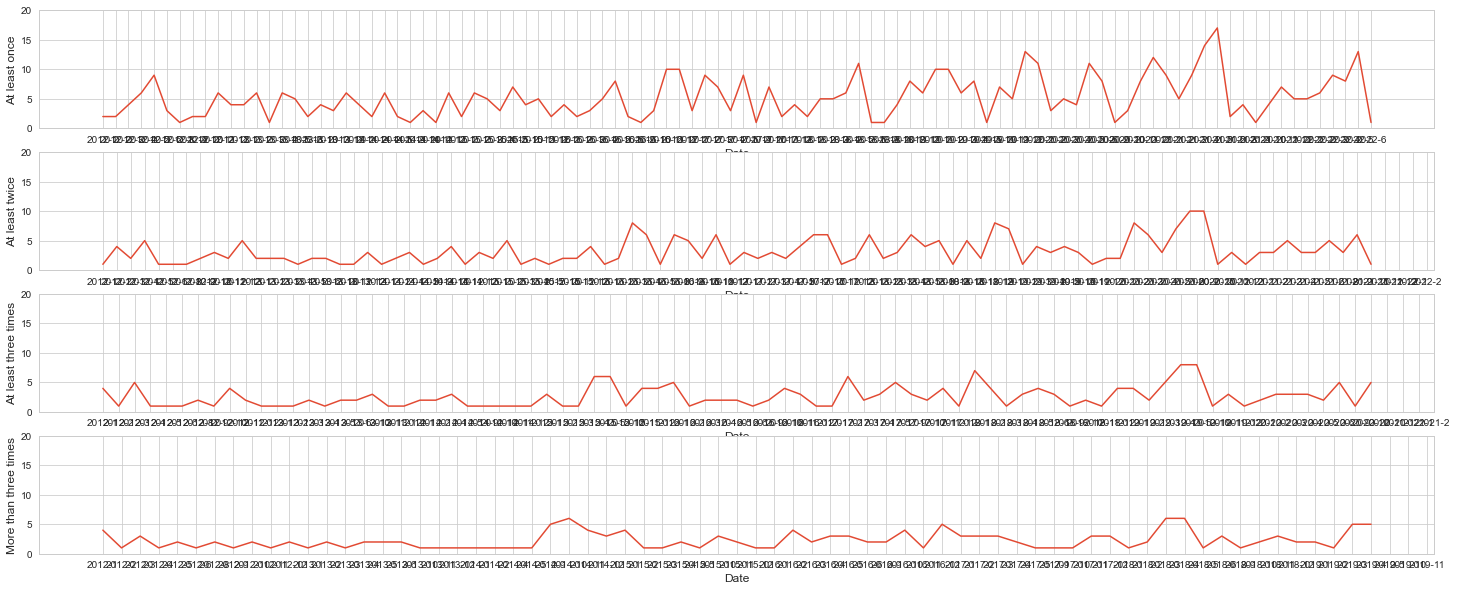

In [61]:
plt.style.use('ggplot')
sns.set_style("whitegrid")

fig, ax = plt.subplots(nrows=4, ncols=1, sharey=False, figsize=(25,10))

ax[0] = sns.lineplot(x = 'Date', y = "At least once", data=ft_freq_df, ax=ax[0])
ax[0].set(ylim=(0, 20))
ax[1] = sns.lineplot(x = 'Date', y = "At least twice", data=ft_freq_df, ax=ax[1])
ax[1].set(ylim=(0, 20))

ax[2] = sns.lineplot(x = 'Date', y = "At least three times", data=ft_freq_df, ax=ax[2])
ax[2].set(ylim=(0, 20))

ax[3] = sns.lineplot(x = 'Date', y = "More than three times", data=ft_freq_df, ax=ax[3])
ax[3].set(ylim=(0, 20))


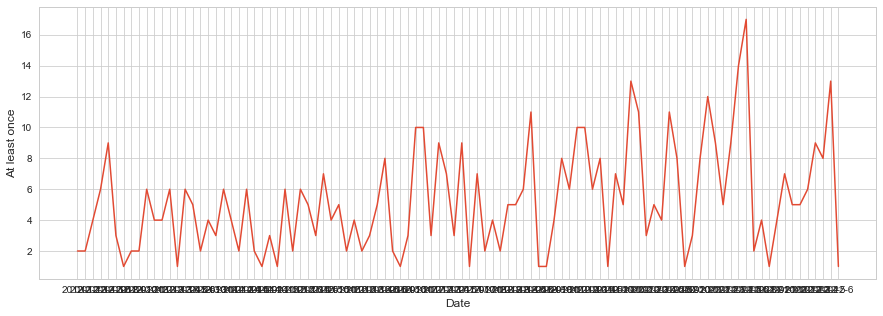

In [62]:
plt.style.use('ggplot')
sns.set_style("whitegrid")

fig, ax = plt.subplots(nrows=1, ncols=1, sharey=False, figsize=(15,5))

ax = sns.lineplot(x = 'Date', y = "At least once", data=ft_freq_df)



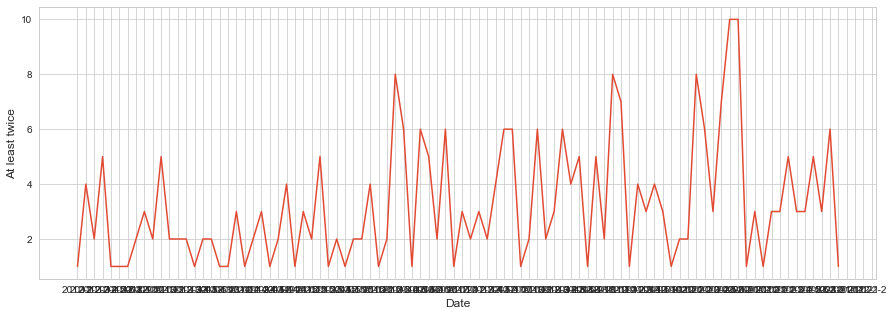

In [63]:
plt.style.use('ggplot')
sns.set_style("whitegrid")

fig, ax = plt.subplots(nrows=1, ncols=1, sharey=False, figsize=(15,5))

ax = sns.lineplot(x = 'Date', y = "At least twice", data=ft_freq_df)

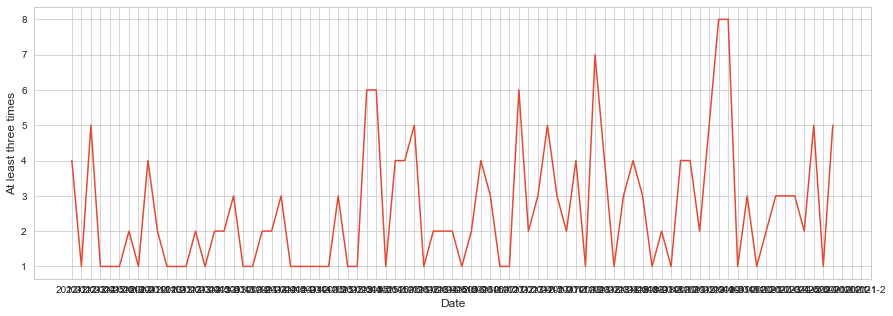

In [64]:
plt.style.use('ggplot')
sns.set_style("whitegrid")

fig, ax = plt.subplots(nrows=1, ncols=1, sharey=False, figsize=(15,5))

ax = sns.lineplot(x = 'Date', y = "At least three times", data=ft_freq_df)

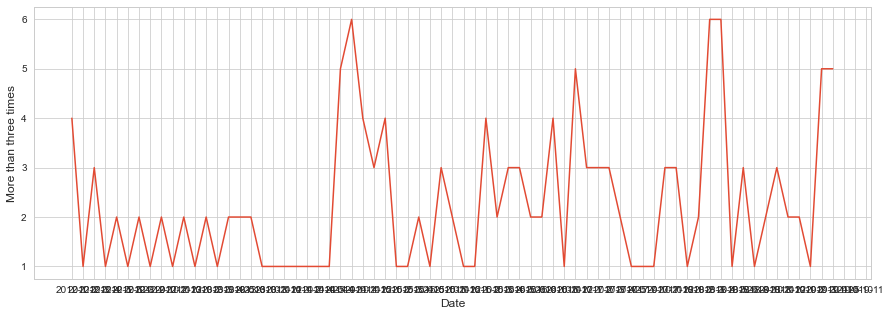

In [65]:
plt.style.use('ggplot')
sns.set_style("whitegrid")

fig, ax = plt.subplots(nrows=1, ncols=1, sharey=False, figsize=(15,5))

ax = sns.lineplot(x = 'Date', y = "More than three times", data=ft_freq_df)

In [66]:
ft['year'] = pd.to_datetime(ft_sygeplej2x["date"]).dt.year
ft['month'] = pd.to_datetime(ft_sygeplej2x["date"]).dt.month
ft_freq = ft.copy()
ft_freq = ft_freq.dropna(subset = ['year', 'month'])

In [67]:
ft_freq = ft.groupby(['year', 'month'])["content"].count()
ft_freq_df = pd.DataFrame(ft_freq).reset_index()
ft_freq_df

,year,month,content
0,2012.0,2.0,1
1,2012.0,3.0,4
2,2012.0,4.0,2
3,2012.0,5.0,5
4,2012.0,8.0,1
...,...,...,...
87,2022.0,2.0,3
88,2022.0,3.0,5
89,2022.0,4.0,3
90,2022.0,5.0,6


In [68]:
tv2_freq_df['date']=tv2_freq_df['year'].astype(str)+tv2_freq_df['month'].astype(str)

NameError: name 'tv2_freq_df' is not defined

In [18]:
tv2_freq

year    month
2012.0  1.0       3
        2.0       7
        3.0      32
        4.0       8
        5.0       6
                 ..
2022.0  3.0       4
        4.0       8
        5.0       1
        6.0       3
        7.0      15
Name: content, Length: 124, dtype: int64

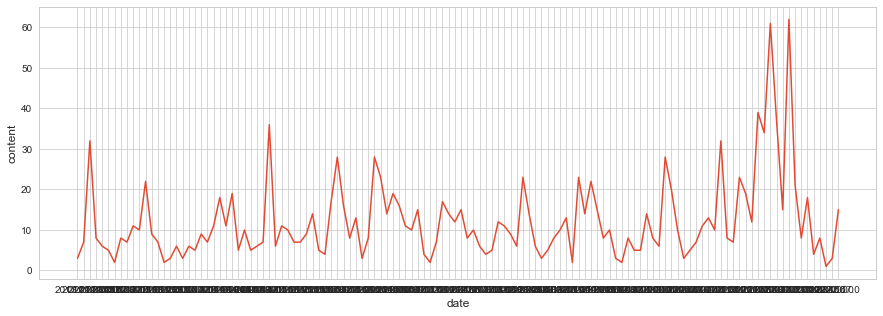

In [19]:
# Plotting count of tags
plt.style.use('ggplot')
sns.set_style("whitegrid")

fig, ax = plt.subplots(nrows=1, ncols=1, sharey=False, figsize=(15,5))

ax = sns.lineplot(x = 'date', y = 'content', data= tv2_freq_df )

## Analysis of Tags

### Most frequent Tags

In [197]:
# Define tag-count function
def tag_count(df):
    df_tags=df["tag"].value_counts()
    df_tags=pd.DataFrame(df_tags).reset_index(drop=False)
    df_tags.columns=("tags", "count")
    return df_tags

# Call function
tv2_tags = tag_count(tv2_sygeplej2x)
dr_tags = tag_count(dr_sygeplej2x)

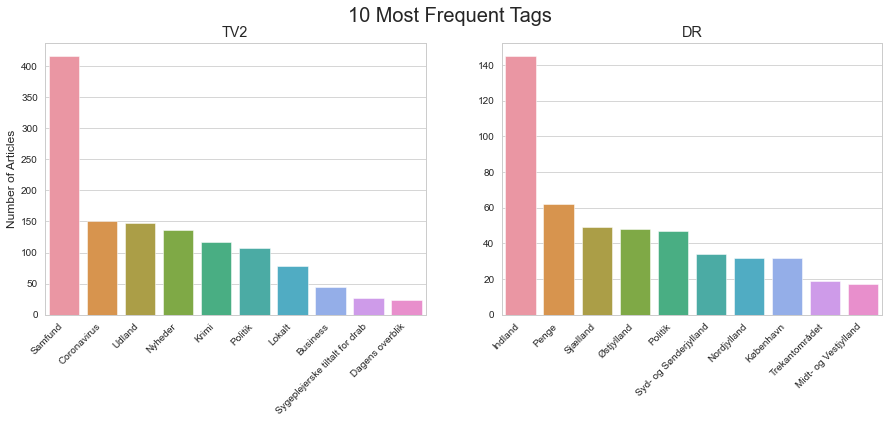

In [223]:
# Plotting count of tags
plt.style.use('ggplot')
sns.set_style("whitegrid")

fig, ax = plt.subplots(nrows=1, ncols=2, sharey=False, figsize=(15,5))

ax[0] = sns.barplot(x = tv2_tags["tags"][0:10], y = tv2_tags["count"], orient ="v", ax = ax[0])
ax[1] = sns.barplot(x = dr_tags["tags"][0:10], y = dr_tags["count"], orient ="v", ax = ax[1])

_ = ax[1].set_xticklabels(ax[1].get_xticklabels(), rotation=45, horizontalalignment='right')
_ = ax[0].set_xticklabels(ax[0].get_xticklabels(), rotation=45, horizontalalignment='right')

_ = plt.suptitle("10 Most Frequent Tags", size = 20)
_ = ax[0].set_title("TV2")
_ = ax[1].set_title("DR")
_ = ax[0].set_ylabel("Number of Articles")
_ = ax[1].set_ylabel("")

_ = ax[0].set(xlabel=None)
_ = ax[1].set(xlabel=None)

### Usage of tags over time